# TTST Super-Resolution Inference (Improved Version)

In [1]:
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from model_archs.TTST_arc import TTST
import os
import torch.nn.functional as F
from collections import OrderedDict

In [2]:
# --- Configuration ---
UPSCALE_FACTOR = 4
MODEL_PATH = 'saved_models/ttst_4x.pth'
INPUT_IMAGE_PATH = 'sample/farmland_153.JPG'
OUTPUT_IMAGE_PATH = 'sample/farmland_153_sr.png'
GPU_MODE = torch.cuda.is_available()

In [3]:
# --- Load Model ---
model = TTST()

# Load the state dict
if GPU_MODE:
    state_dict = torch.load(MODEL_PATH)
else:
    state_dict = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# Create a new state dict without the 'module.' prefix
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.' of dataparallel
    new_state_dict[name] = v

# Load the new state dict
model.load_state_dict(new_state_dict)

if GPU_MODE:
    model = model.cuda()

model.eval()

c:\Users\AIDL_\anaconda3\envs\env01\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TTST(
  (conv_first): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RTSG(
      (residual_group): AttenBlocks(
        (blocks): ModuleList(
          (0): HAB(
            (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=180, out_features=540, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=180, out_features=180, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (conv_block): Attention(
              (qkv): Conv2d(180, 540, kernel_size=(1, 1), stride=(1, 1))
              (qkv_dwconv): Conv2d(540, 540, kernel_size=(3, 3), stri

In [4]:
INPUT_IMAGE_PATH = 'sample/school_252.png'
OUTPUT_IMAGE_PATH = INPUT_IMAGE_PATH+'_sr.png'

In [5]:
# --- Load and Preprocess Image ---
transform = transforms.Compose([transforms.ToTensor()])
img = Image.open(INPUT_IMAGE_PATH).convert('RGB')

# Store original image dimensions for unpadding later
original_h, original_w = img.height, img.width

lr_tensor = transform(img).unsqueeze(0)

# Pad the input image to be divisible by the window size (8)
window_size = 8
h, w = lr_tensor.shape[2:]
mod_pad_h = (window_size - h % window_size) % window_size
mod_pad_w = (window_size - w % window_size) % window_size
lr_tensor = F.pad(lr_tensor, (0, mod_pad_w, 0, mod_pad_h), 'reflect')

if GPU_MODE:
    lr_tensor = lr_tensor.cuda()

In [6]:
# --- Run Inference ---
with torch.no_grad():
    prediction = model(lr_tensor)

In [7]:
# --- Post-process and Save Image ---
prediction = prediction.cpu().data[0].numpy()
prediction = prediction * 255.0
prediction = prediction.clip(0, 255)
prediction = prediction.transpose(1, 2, 0)

# Remove the padding from the super-resolved image
# The output image will be UPSCALE_FACTOR times larger than the padded input
sr_h, sr_w, _ = prediction.shape
# Calculate the original (unpadded) dimensions scaled by UPSCALE_FACTOR
target_sr_h = original_h * UPSCALE_FACTOR
target_sr_w = original_w * UPSCALE_FACTOR

prediction = prediction[:target_sr_h, :target_sr_w, :]

sr_image = Image.fromarray(np.uint8(prediction))
sr_image.save(OUTPUT_IMAGE_PATH)
print(f'Super-resolved image saved to {OUTPUT_IMAGE_PATH}')

Super-resolved image saved to sample/school_252.png_sr.png


## Display Results

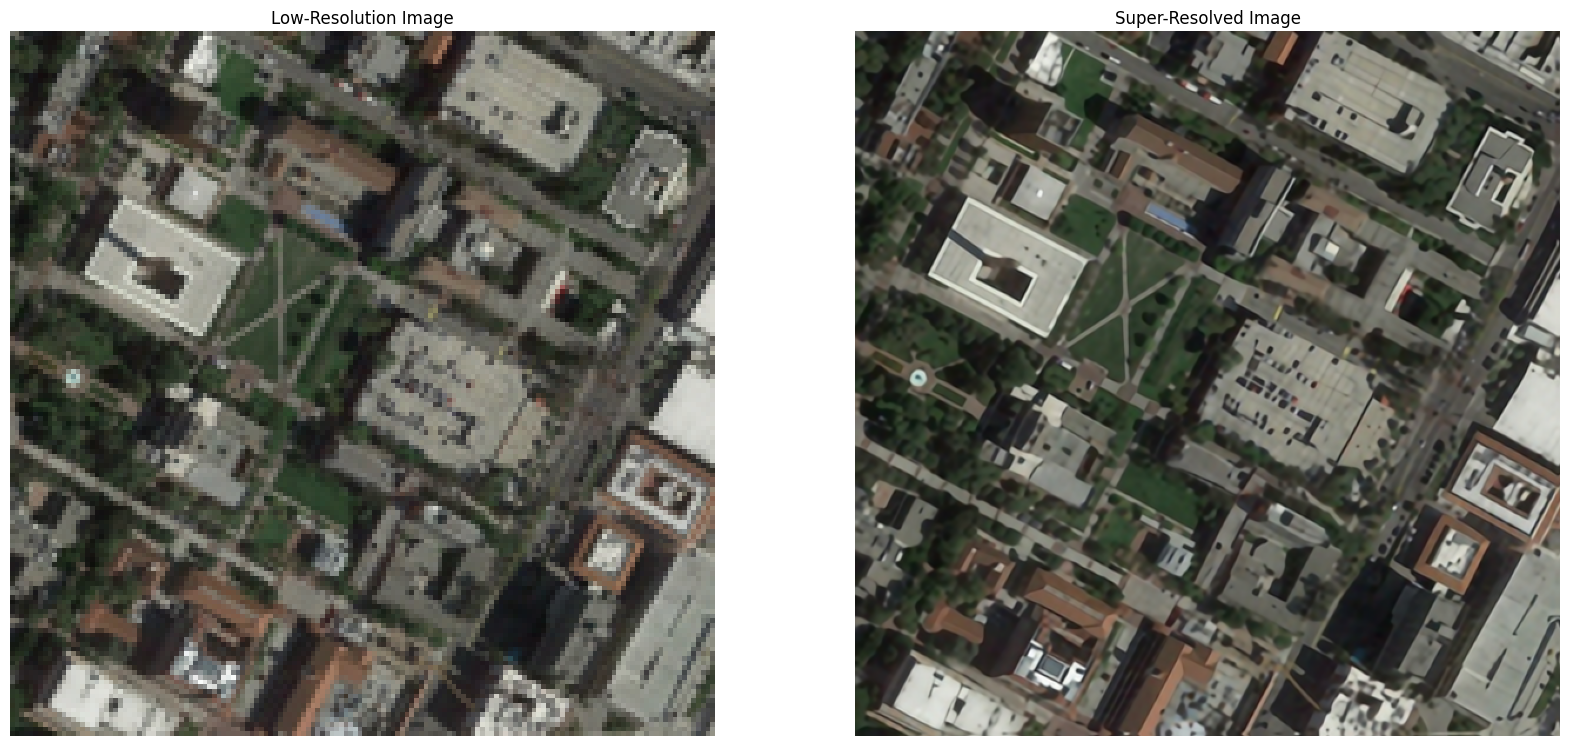

In [9]:
import matplotlib.pyplot as plt

lr_image = Image.open(INPUT_IMAGE_PATH)
sr_image_display = Image.open(OUTPUT_IMAGE_PATH)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Low-Resolution Image')
plt.imshow(lr_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Super-Resolved Image')
plt.imshow(sr_image_display)
plt.axis('off')

plt.show()